In [165]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import copy

import sys
sys.path.insert(0, "../models/")
from relu_nn import FFReLUNet

In [166]:
# Make the graph
N = 5
G = nx.erdos_renyi_graph(N, 0.6)
nx.is_connected(G)

True

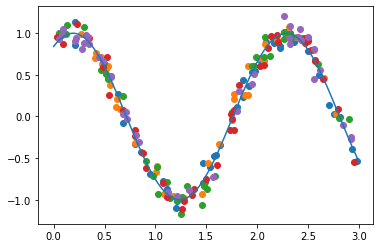

In [167]:
# Setup data
xdom = [0.0, 3.0]
num_samps = 40
freq = 3.0
phase = 1.0
amp = 1.0
noise = 0.1

testx = torch.arange(xdom[0], xdom[1], 0.01).reshape(-1, 1)
testy = amp * torch.sin(freq * testx + phase).reshape(-1, 1)

fig, ax = plt.subplots()
dataset = {}
for i in range(N):
    x = (xdom[1] - xdom[0]) * torch.rand(num_samps) + xdom[0]
    y = amp * torch.sin(freq * x + phase) + noise * torch.randn(num_samps)
    dataset[i] = {"x": x.reshape(-1, 1), "y": y.reshape(-1, 1)}
    ax.scatter(x, y)
ax.plot(testx, testy)
plt.show()

In [168]:
# Setup models
shape = [1, 16, 16, 1]
base_model = FFReLUNet(shape)
n = torch.nn.utils.parameters_to_vector(base_model.parameters()).shape[0]

models = {i : copy.deepcopy(base_model) for i in range(N)}
t1 = torch.nn.utils.parameters_to_vector(models[0].parameters())

In [169]:
# Setup loss functions
def cadmm_loss(base_loss, pred, target, model, dual, thj, rho):
    th = torch.nn.utils.parameters_to_vector(model.parameters())
    reg = torch.sum(torch.square(torch.cdist(th.reshape(1, -1), thj.reshape(1, -1))))
    return base_loss(pred, target) + torch.dot(th, dual) + rho * reg

In [170]:
def primal_update(data, model, base_loss, dual, thj, rho, lr, max_its):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for k in range(max_its):
        opt.zero_grad()
        
        yh = model.forward(data["x"])
        
        th = torch.nn.utils.parameters_to_vector(model.parameters())
        reg = torch.sum(torch.square(torch.cdist(th.reshape(1, -1), thj)))
        loss = base_loss(yh, data["y"]) + torch.dot(th, dual) + rho * reg

        loss.backward()
        opt.step()

def joint_loss(base_loss, testx, testy, models, N):
    with torch.no_grad():
        loss = 0.0
        for i in range(N):
            pred = models[i].forward(testx)
            loss += base_loss(pred, testy)
        return loss

In [171]:
max_its_cadmm = 400
max_its_adam = 15
rho = 0.5
lr = 0.005


duals = {i : torch.zeros(n) for i in range(N)}
objv = torch.zeros(max_its_cadmm)

for k in range(max_its_cadmm):
    # Freeze all of the model parameters for intermediary steps
    ths = {i : (torch.nn.utils.parameters_to_vector(models[i].parameters()).clone().detach()) for i in range(N)}

    for i in range(N):
        # Communication
        neighs = list(G.neighbors(i))
        thj = torch.stack([ths[j] for j in neighs])

        # Update the dual var
        duals[i] += rho * torch.sum(ths[i] - thj, dim=0)

        # Primal Update
        primal_update(dataset[i], models[i], torch.nn.MSELoss(), duals[i], thj, rho, lr, max_its_adam)

    objv[k] = joint_loss(torch.nn.MSELoss(), testx, testy, models, N)

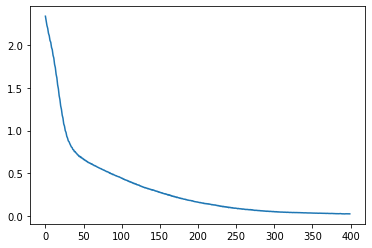

In [172]:
fig, ax = plt.subplots()

ax.plot(objv.detach().numpy())

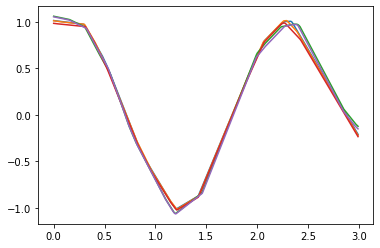

In [173]:
fig, ax = plt.subplots()

for i in range(N):
    ax.plot(testx, models[i].forward(testx).detach().numpy())